# internal note v 3.3 Aug-20, 2017

In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
%matplotlib inline

# pp-SRC c.m. analysis

In [2]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]

In [3]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials","NoPrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_x_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_x_unweighted']) - np.square(0.02))
    cm_pars['sigma_x_before_acc_corr_err'] = cm_pars['sigma_xErr_unweighted']
    cm_pars['sigma_y_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_y_unweighted']) - np.square(0.02))
    cm_pars['sigma_y_before_acc_corr_err'] = cm_pars['sigma_yErr_unweighted']
    cm_pars['sigma_t_before_acc_corr'] = 0.5*(cm_pars['sigma_x_unweighted']+cm_pars['sigma_y_unweighted'])
    cm_pars['sigma_t_before_acc_corr_err'] = 0.5*np.sqrt(np.square(cm_pars['sigma_x_before_acc_corr_err'])+np.square(cm_pars['sigma_y_before_acc_corr_err']))
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars

## cm_parameters['PrecFiducials']

In [4]:
targets = ['C','Al','Fe','Pb']
As = [12,27,56,208]

In [23]:
simulation_results = dict()
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):#{
            test_name = "simulations_"+target
            simulation_results[test_name] = pd.concat([pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/simulation_300Pmiss600_"+target+"_runs_0_10runs_results.csv")
                                                       ,pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/PrecFiducialsNominal_"+target+".csv")
                                                       ,pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/simulation_300Pmiss600_"+target+"_runs_0_100runs_results.csv")])
            simulation_results[test_name].fillna(-1,inplace=True)
            print len(simulation_results[test_name]),'events in ',test_name

3846 events in  simulations_C
1403 events in  simulations_Al
1403 events in  simulations_Fe
1403 events in  simulations_Pb


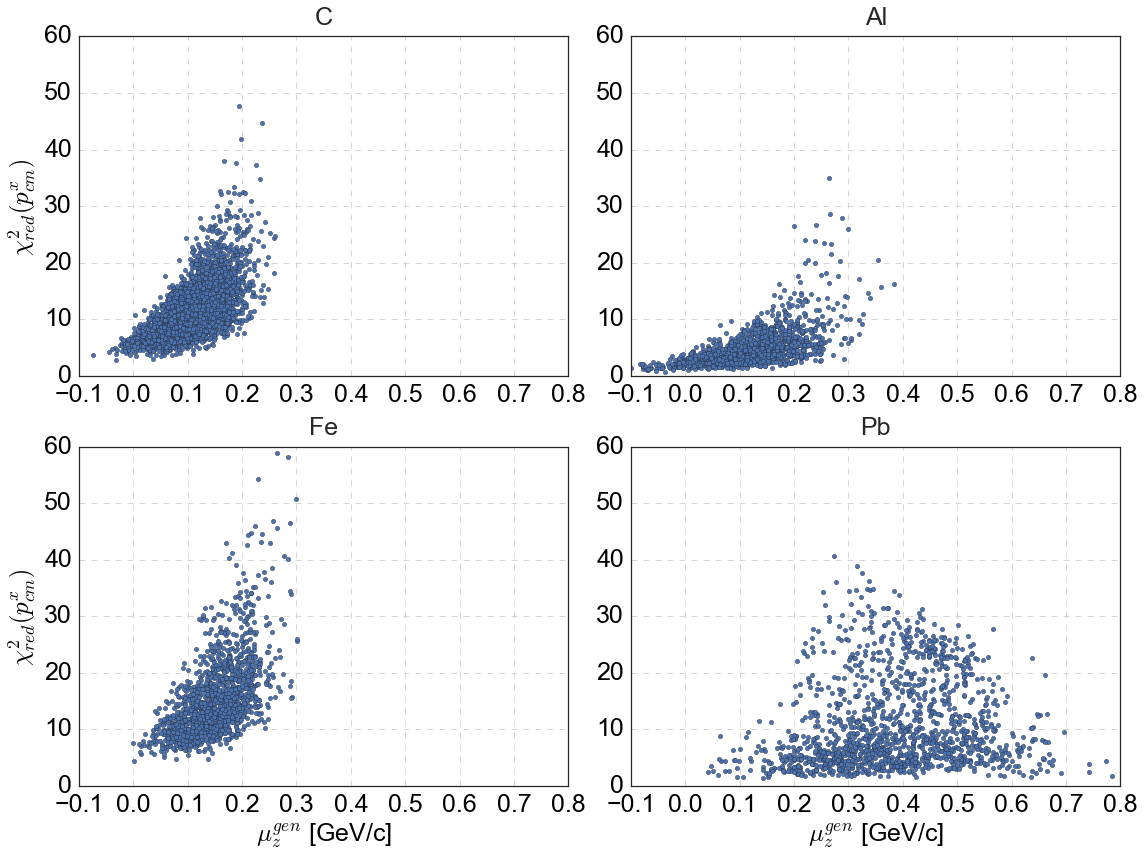

In [25]:
poly_degree = 3 # fit polynomial degree
confidence_interval = 0.68 # band around fit
Fiducials = "PrecFiducials"
fig=plt.figure(figsize=(16,12))
for i,(A,target) in enumerate(zip(As,targets)):#{
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    ax=fig.add_subplot(2,2,i+1)
    plt.scatter(sims['gen_MeanZ'],sims['chi2red_x'])    
    set_axes(ax,r'$\mu_z^{gen}$ [GeV/c]' if i>=2 else ''
             ,r'$\chi^2_{red} \left( p_{cm}^x \right)$' if i==0 or i==2 else ''
             ,title=target,xlim=(-0.1,0.8),ylim=(-0.1,60),do_add_grid=True)    
plt.tight_layout()

# fig=plt.figure(figsize=(16,12))
# for i,(A,target) in enumerate(zip(As,targets)):#{
#     test_name = "simulations_"+target
#     sims=simulation_results[test_name]
#     ax=fig.add_subplot(2,2,i+1)
#     plt.scatter(sims['gen_MeanZ'],sims['chi2red_y'])    
#     set_axes(ax,r'$\mu_z^{gen}$ [GeV/c]' if i>=2 else ''
#              ,r'$\chi^2_{red} \left( p_{cm}^y \right)$' if i==0 or i==2 else ''
#              ,title=target,xlim=(-0.1,0.8),ylim=(-0.1,60),do_add_grid=True)    
# plt.tight_layout()

# fig=plt.figure(figsize=(16,12))
# for i,(A,target) in enumerate(zip(As,targets)):#{
#     test_name = "simulations_"+target
#     sims=simulation_results[test_name]
#     ax=fig.add_subplot(2,2,i+1)
#     plt.scatter(sims['gen_MeanZ'],sims['chi2red_z'])    
#     set_axes(ax,r'$\mu_z^{gen}$ [GeV/c]' if i>=2 else ''
#              ,r'$\chi^2_{red} \left( p_{cm}^z \right)$' if i==0 or i==2 else ''
#              ,title=target,xlim=(-0.1,0.8),ylim=(-0.1,60),do_add_grid=True)    
# plt.tight_layout()

In [19]:
def find_x_poly(poly,y0,xmin=0,xmax=0.3):
    p = np.poly1d(poly)
    roots = (p - y0).roots
    for root in roots:
        if xmin<root and root<xmax:
            x_poly = root
    return x_poly

In [11]:
def plot_cm_direction(simulations_results=None
                      ,Fiducials='PrecFiducials'
                      ,extraname=""
                      ,ax=None,A=12
                      ,poly_degree=3
                      ,confidence_interval = 0.68
                      ,direction='x',colors=['blue','royalblue'],s=50
                      ,debug=0):

    gen,rec = simulations_results['gen_Sigma_t'],simulations_results['rec_sigma_'+direction]
    plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    if debug:  print "plt.scatter()"
    # fit a polynomial of order 2
    popt,cov = np.polyfit( gen,rec , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace(np.min(ax.get_xlim()),np.max(ax.get_xlim()),1000)
    poly = np.poly1d(popt)
    ax.plot(x,poly(x),'-',color='black',linewidth=2,label='best fit')    
    
    # Convert to percentile point of the normal distribution [https://en.wikipedia.org/wiki/Standard_score]
    pp = (1. + confidence_interval) / 2.
    # Convert to number of standard deviations.
    nstd = stats.norm.ppf(pp)
    
    # Add nstd standard deviations to parameters to obtain the upper confidence interval
    poly_up = np.poly1d(popt + nstd * perr)
    ax.plot(x,poly_up(x),'-',color='gray',linewidth=2)
    poly_dw = np.poly1d(popt - nstd * perr)
    ax.plot(x,poly_dw(x),'-',color='gray',linewidth=2)
    
    cm_pars = cm_parameters[Fiducials]    
    cm_pars_target = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    # reconstructed \sigma in data
    if debug:  print cm_pars_target
    sigma_meas, sigma_meas_err = float(cm_pars_target['sigma_'+direction+'_before_acc_corr']), float(cm_pars_target['sigma_'+direction+'_before_acc_corr_err'])
    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    label_corr = '$%.3f$'%(corr_value)
    plt.plot( np.linspace(np.min(ax.get_xlim()),corr_value,1000) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)
    
    plt.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    plt.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # systematical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_sys = find_x_poly(poly_dw,sigma_meas+sigma_meas_err)
    x_poly_dw_sys = find_x_poly(poly_up,sigma_meas-sigma_meas_err)
    corr_val_up_err_sys = x_poly_up_sys - x_poly_up_stat
    corr_val_dw_err_sys = x_poly_dw_stat - x_poly_dw_sys
    label_unc_sys = '$(^{+%.0f}_{-%.0f})_{sys.}$'%(1000*corr_val_up_err_sys,1000*corr_val_dw_err_sys)



    if debug:  print "plt.plot( np.linspace(np.min(ax.get_xlim()),corr_value,1000)..."   
    # projection of the measured uncertainties
    plt.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_sys,1000) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    plt.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_sys,1000) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    # projection of the systematical uncertainties
    plt.plot( [x_poly_up_sys,x_poly_up_sys] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='grey' ,linestyle='-')
    plt.plot( [x_poly_dw_sys,x_poly_dw_sys] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    if debug:  print "plugging",'sigma_'+direction+'_corrected'+extraname
    
    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_up_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_dw_err_sys))
    
    plt.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[0]
             ,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
        
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value)
    
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_sys'+extraname,corr_val_up_err_sys)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_sys'+extraname,corr_val_dw_err_sys)

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
             
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0,0.05,0.1,0.15,0.2,0.25,0.3] , yticks=[0,0.05,0.1,0.15,0.2,0.25,0.3] , do_add_grid=True 
             ,title = cm_pars_target['target'].to_string(index=False) + ', $'+direction+'-direction$ ('+Fiducials+')')

    ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    ax.set_xlim(0,0.3);ax.set_ylim(0,0.3);
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

In [32]:
for Fiducials in ['PrecFiducials']:#,'NoPrecFiducials']:
    sample = cm_parameters_with_correction[Fiducials]
    for direction in ['x','y']:
        sample['sigma_'+direction+'_final'] = sample['sigma_'+direction+'_corrected']
        for updw in ['up','dw']:
            sample['sigma_'+direction+'_final_'+updw+'_err_tot'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot']
            sample['sigma_'+direction+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_final_'+updw+'_err_tot']

    sample['sigma_t_corrected'] = 0.5*(sample['sigma_x_corrected']+sample['sigma_y_corrected'])
    sample['sigma_t_final'] = 0.5*(sample['sigma_x_corrected']+sample['sigma_y_corrected'])

    for err_label in ['stat','sys','tot']:
        for updw in ['up','dw']:
            sample['sigma_t_final_'+updw+'_err_'+err_label] = 0.5*np.sqrt(np.square(sample['sigma_x_corrected_'+updw+'_err_'+err_label])                                                                              
                                                                          +np.square(sample['sigma_y_corrected_'+updw+'_err_'+err_label]))
    for updw in ['up','dw']:
        sample['sigma_t_final_'+updw+'_err'] = sample['sigma_t_final_'+updw+'_err_tot']

Fiducials = "PrecFiducials"
sample = cm_parameters_with_correction[Fiducials]
for extraname in ["_MeanZlinearInPmiss_SigmaZ5stdSroundMeasured","_mean75MeVc_sigma50MeVc"]:
    for direction in ['x','y']:
        sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
        for updw in ['up','dw']:
            sample['sigma_'+direction+extraname+'_final_'+updw+'_err_tot'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]
            sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+extraname+'_final_'+updw+'_err_tot']

    sample['sigma_t'+extraname+'_corrected'] = 0.5*(sample['sigma_x_corrected'+extraname]+sample['sigma_y_corrected'+extraname])
    sample['sigma_t'+extraname+'_final'] = 0.5*(sample['sigma_x_corrected'+extraname]+sample['sigma_y_corrected'+extraname])

    for err_label in ['stat','sys','tot']:
        for updw in ['up','dw']:
            sample['sigma_t'+extraname+'_final_'+updw+'_err_'+err_label] = 0.5*np.sqrt(np.square(sample['sigma_x_corrected_'+updw+'_err_'+err_label+extraname])                                                                         
                                                                                       +np.square(sample['sigma_y_corrected_'+updw+'_err_'+err_label+extraname]))
    for updw in ['up','dw']:
        sample['sigma_t'+extraname+'_final_'+updw+'_err'] = sample['sigma_t_final_'+updw+'_err_tot']